## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm import tqdm
import zipfile
pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = "../input/hubmap-kidney-segmentation"
MASKS = f"{DATA_PATH}/train.csv"
DATA = f"{DATA_PATH}/train/"
SHFT = [0, 0.5]
REDUCE = 1
SIZE = 1024
SAT_THR = 40
PIX_THR = 200 * SIZE // 256

TILES_PATH = f"{DATA_PATH}/tiles_r{REDUCE}_s{SIZE}"
MASKS_PATH = f"{DATA_PATH}/masks_R{REDUCE}_s{SIZE}"


if not os.path.exists(TILES_PATH):
    os.mkdir(TILES_PATH)
    
if not os.path.exists(MASKS_PATH):
    os.mkdir(MASKS_PATH)

In [3]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) -1
            length = int(s[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape).T
        

In [4]:
dfs, paths = [], []
dfs.append(pd.read_csv(MASKS).set_index("id"))
paths.append(DATA)

In [5]:
for df_masks, data_path in zip(dfs, paths):
    print(df_masks.head())
    print(data_path)

                                                    encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...
../input/hubmap-kidney-segmentation/train/


In [6]:
dfs[0]

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f,113277795 21 113315936 53 113354083 87 1133922...


In [7]:
for df_masks, data_path in zip(dfs, paths):
    print(f"processing: {data_path}")
    x_tot, x2_tot = [], []
    for ishift, shift in enumerate(SHFT): #index_shift, shift
        for index, encs in tqdm(df_masks.iterrows(), total = len(df_masks), desc = f"shift {ishift}"):
            img = tiff.imread(os.path.join(data_path, index + ".tiff"))
            print("" * 20)
            print(os.path.join(data_path, index + ".tiff"))
            print(f"img shape: {img.shape}")
            if len(img.shape) == 5:
                img = np.transpose(img.squeeze(), (1, 2, 0))
            if img.shape[0] == 3: 
                img = np.transpose(img.squeeze(), (1, 2, 0))
            mask = enc2mask(encs, (img.shape[1], img.shape[0]))
            
            shape = img.shape
            try:
                print("before pad img shape:", img.shape)
                pad0 = (REDUCE * SIZE - shape[0] % (REDUCE * SIZE)) % (REDUCE * SIZE)
                
                pad1 = (REDUCE * SIZE - shape[1] % (REDUCE * SIZE)) % (REDUCE * SIZE)
                
                img = np.pad(img, 
                             [
                                 [pad0 // 2, pad0 - pad0 // 2],
                                 [pad1 // 2, pad1 - pad1 // 2],
                                 [0, 0]
                             ], constant_values = 0)
                
                img = img[
                    0 + int(REDUCE * SIZE * shift) : img.shape[0] - int(REDUCE * SIZE * shift),
                    0 + int(REDUCE * SIZE * shift) : img.shape[1] - int(REDUCE * SIZE * shift),
                    :]
                
                mask = np.pad(mask,
                              [[pad0 // 2, pad0 - pad0 // 2],
                               [pad1 // 2, pad1 - pad1 // 2]],
                              constant_values = 0)
                
                mask = mask[
                    0 + int(REDUCE * SIZE * shift) : mask.shape[0] - int(REDUCE * SIZE * shift),
                    0 + int(REDUCE * SIZE * shift) : mask.shape[1] - int(REDUCE * SIZE * shift)
                ]
                
                img = cv2.resize(img,
                                 (img.shape[1] // REDUCE, img.shape[0] // REDUCE),
                                 interpolation = cv2.INTER_AREA)
                
                img = img.reshape(img.shape[0] // SIZE, SIZE, img.shape[1] // SIZE, SIZE, 3)
                
                img = img.transpose(0, 2, 1, 3, 4).reshape(-1, SIZE, SIZE, 3)
                
                mask = cv2.resize(mask,
                                  (mask.shape[1] // REDUCE, mask.shape[0] // REDUCE),
                                  interpolation = cv2.INTER_NEAREST)
                
                mask = mask.reshape(mask.shape[0] // SIZE, SIZE, mask.shape[1] // SIZE, SIZE)
                
                mask = mask.transpose(0, 2, 1, 3).reshape(-1, SIZE, SIZE)

                for i, (im, m) in enumerate(zip(img, mask)):
                    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
                    h, s, v = cv2.split(hsv)
                    if (s > SAT_THR).sum() <= PIX_THR or im.sum() <= PIX_THR:
                        continue
                        
                    x_tot.append((im / 255).reshape(-1, 3).mean(0))
                    x2_tot.append(((im / 255) ** 2).reshape(-1, 3).mean(0))
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                    is_written = cv2.imwrite(f"{TILES_PATH}/{index}_{i}_{ishift}.png", im)
                    if not is_written:
                        print("error writing to file ", f"{TILES_PATH}/{index}_{i}_{ishift}.png")
                    is_written = cv2.imwrite(f"{MASKS_PATH}/{index}_{i}_{ishift}.png", m)
                    if not is_written:
                        print(f"error writing to file {MASKS_PATH}/{index}_{i}_{ishift}.png")
            except:
                print("error", shape)
                
    img_avg = np.array(x_tot).mean(0)
    img_std = np.sqrt(np.array(x2_tot).mean(0) - img_avg ** 2)
    print("mean:", img_avg, "| std:", img_std)

shift 0:   0%|                                                                                  | 0/15 [00:00<?, ?it/s]

processing: ../input/hubmap-kidney-segmentation/train/

../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff
img shape: (31278, 25794, 3)
before pad img shape: (31278, 25794, 3)


C:\Users\apist\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
shift 0:   7%|████▉                                                                     | 1/15 [00:46<10:53, 46.69s/it]


../input/hubmap-kidney-segmentation/train/8242609fa.tiff
img shape: (31299, 44066, 3)
before pad img shape: (31299, 44066, 3)


shift 0:  13%|█████████▊                                                                | 2/15 [02:18<15:48, 73.00s/it]


../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff
img shape: (18484, 13013, 3)
before pad img shape: (18484, 13013, 3)


shift 0:  20%|██████████████▊                                                           | 3/15 [02:34<09:27, 47.32s/it]


../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff
img shape: (34940, 49548, 3)
before pad img shape: (34940, 49548, 3)


shift 0:  27%|███████████████████▋                                                      | 4/15 [04:28<13:26, 73.33s/it]


../input/hubmap-kidney-segmentation/train/b9a3865fc.tiff
img shape: (31295, 40429, 3)
before pad img shape: (31295, 40429, 3)


shift 0:  33%|████████████████████████▋                                                 | 5/15 [05:58<13:14, 79.41s/it]


../input/hubmap-kidney-segmentation/train/b2dc8411c.tiff
img shape: (14844, 31262, 3)
before pad img shape: (14844, 31262, 3)


shift 0:  40%|█████████████████████████████▌                                            | 6/15 [06:25<09:15, 61.74s/it]


../input/hubmap-kidney-segmentation/train/0486052bb.tiff
img shape: (25784, 34937, 3)
before pad img shape: (25784, 34937, 3)


shift 0:  47%|██████████████████████████████████▌                                       | 7/15 [07:14<07:39, 57.42s/it]


../input/hubmap-kidney-segmentation/train/e79de561c.tiff
img shape: (1, 1, 3, 16180, 27020)
before pad img shape: (16180, 27020, 3)


shift 0:  53%|███████████████████████████████████████▍                                  | 8/15 [07:53<06:01, 51.70s/it]


../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff
img shape: (3, 38160, 39000)
before pad img shape: (38160, 39000, 3)


shift 0:  60%|████████████████████████████████████████████▍                             | 9/15 [09:24<06:23, 63.88s/it]


../input/hubmap-kidney-segmentation/train/54f2eec69.tiff
img shape: (1, 1, 3, 30440, 22240)
before pad img shape: (30440, 22240, 3)


shift 0:  67%|████████████████████████████████████████████████▋                        | 10/15 [10:04<04:42, 56.44s/it]


../input/hubmap-kidney-segmentation/train/4ef6695ce.tiff
img shape: (3, 39960, 50680)
before pad img shape: (39960, 50680, 3)


shift 0:  73%|█████████████████████████████████████████████████████▌                   | 11/15 [12:31<05:36, 84.15s/it]


../input/hubmap-kidney-segmentation/train/26dc41664.tiff
img shape: (3, 38160, 42360)
before pad img shape: (38160, 42360, 3)


shift 0:  80%|██████████████████████████████████████████████████████████▍              | 12/15 [14:08<04:24, 88.28s/it]


../input/hubmap-kidney-segmentation/train/c68fe75ea.tiff
img shape: (3, 26840, 49780)
before pad img shape: (26840, 49780, 3)


shift 0:  87%|██████████████████████████████████████████████████████████████▍         | 13/15 [16:17<03:21, 100.56s/it]


../input/hubmap-kidney-segmentation/train/afa5e8098.tiff
img shape: (36800, 43780, 3)
before pad img shape: (36800, 43780, 3)


shift 0:  93%|███████████████████████████████████████████████████████████████████▏    | 14/15 [18:40<01:53, 113.33s/it]


../input/hubmap-kidney-segmentation/train/1e2425f28.tiff
img shape: (3, 26780, 32220)
before pad img shape: (26780, 32220, 3)


shift 1:   0%|                                                                                  | 0/15 [00:00<?, ?it/s]


../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff
img shape: (31278, 25794, 3)
before pad img shape: (31278, 25794, 3)


shift 1:   7%|████▉                                                                     | 1/15 [00:42<09:57, 42.69s/it]


../input/hubmap-kidney-segmentation/train/8242609fa.tiff
img shape: (31299, 44066, 3)
before pad img shape: (31299, 44066, 3)


shift 1:  13%|█████████▊                                                                | 2/15 [02:12<15:13, 70.25s/it]


../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff
img shape: (18484, 13013, 3)
before pad img shape: (18484, 13013, 3)


shift 1:  20%|██████████████▊                                                           | 3/15 [02:27<08:59, 44.94s/it]


../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff
img shape: (34940, 49548, 3)
before pad img shape: (34940, 49548, 3)


shift 1:  27%|███████████████████▋                                                      | 4/15 [04:12<12:38, 68.94s/it]


../input/hubmap-kidney-segmentation/train/b9a3865fc.tiff
img shape: (31295, 40429, 3)
before pad img shape: (31295, 40429, 3)


shift 1:  33%|████████████████████████▋                                                 | 5/15 [05:40<12:36, 75.61s/it]


../input/hubmap-kidney-segmentation/train/b2dc8411c.tiff
img shape: (14844, 31262, 3)
before pad img shape: (14844, 31262, 3)


shift 1:  40%|█████████████████████████████▌                                            | 6/15 [06:05<08:46, 58.49s/it]


../input/hubmap-kidney-segmentation/train/0486052bb.tiff
img shape: (25784, 34937, 3)
before pad img shape: (25784, 34937, 3)


shift 1:  47%|██████████████████████████████████▌                                       | 7/15 [06:49<07:11, 53.88s/it]


../input/hubmap-kidney-segmentation/train/e79de561c.tiff
img shape: (1, 1, 3, 16180, 27020)
before pad img shape: (16180, 27020, 3)


shift 1:  53%|███████████████████████████████████████▍                                  | 8/15 [07:28<05:42, 48.94s/it]


../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff
img shape: (3, 38160, 39000)
before pad img shape: (38160, 39000, 3)


shift 1:  60%|████████████████████████████████████████████▍                             | 9/15 [08:56<06:07, 61.18s/it]


../input/hubmap-kidney-segmentation/train/54f2eec69.tiff
img shape: (1, 1, 3, 30440, 22240)
before pad img shape: (30440, 22240, 3)


shift 1:  67%|████████████████████████████████████████████████▋                        | 10/15 [09:35<04:31, 54.37s/it]


../input/hubmap-kidney-segmentation/train/4ef6695ce.tiff
img shape: (3, 39960, 50680)
before pad img shape: (39960, 50680, 3)


shift 1:  73%|█████████████████████████████████████████████████████▌                   | 11/15 [12:01<05:29, 82.30s/it]


../input/hubmap-kidney-segmentation/train/26dc41664.tiff
img shape: (3, 38160, 42360)
before pad img shape: (38160, 42360, 3)


shift 1:  80%|██████████████████████████████████████████████████████████▍              | 12/15 [13:36<04:19, 86.37s/it]


../input/hubmap-kidney-segmentation/train/c68fe75ea.tiff
img shape: (3, 26840, 49780)
before pad img shape: (26840, 49780, 3)


shift 1:  87%|███████████████████████████████████████████████████████████████▎         | 13/15 [15:40<03:15, 97.61s/it]


../input/hubmap-kidney-segmentation/train/afa5e8098.tiff
img shape: (36800, 43780, 3)
before pad img shape: (36800, 43780, 3)


shift 1:  93%|███████████████████████████████████████████████████████████████████▏    | 14/15 [17:59<01:50, 110.31s/it]


../input/hubmap-kidney-segmentation/train/1e2425f28.tiff
img shape: (3, 26780, 32220)
before pad img shape: (26780, 32220, 3)


shift 1: 100%|█████████████████████████████████████████████████████████████████████████| 15/15 [19:06<00:00, 76.40s/it]

mean: [0.63869148 0.48969989 0.6785109 ] | std: [0.19717197 0.25199017 0.1835183 ]


In [8]:
print(len(os.listdir(TILES_PATH)))
print(os.listdir(TILES_PATH)[:10])
print(len(os.listdir(MASKS_PATH)))
print(os.listdir(MASKS_PATH)[:10])
images = set([x[:x.find('_')] for x in os.listdir(TILES_PATH)])
print(images)
images = set([x[:x.find('_')] for x in os.listdir(MASKS_PATH)])
print(images)

21540
['0486052bb_100_0.png', '0486052bb_101_0.png', '0486052bb_104_1.png', '0486052bb_108_0.png', '0486052bb_10_0.png', '0486052bb_110_1.png', '0486052bb_111_1.png', '0486052bb_112_1.png', '0486052bb_113_0.png', '0486052bb_113_1.png']
21540
['0486052bb_100_0.png', '0486052bb_101_0.png', '0486052bb_104_1.png', '0486052bb_108_0.png', '0486052bb_10_0.png', '0486052bb_110_1.png', '0486052bb_111_1.png', '0486052bb_112_1.png', '0486052bb_113_0.png', '0486052bb_113_1.png']
{'c68fe75ea', '8242609fa', '4ef6695ce', 'b9a3865fc', '095bf7a1f', '2f6ecfcdf', 'afa5e8098', '0486052bb', 'cb2d976f4', '54f2eec69', '1e2425f28', 'e79de561c', 'aaa6a05cc', '26dc41664', 'b2dc8411c'}
{'c68fe75ea', '8242609fa', '4ef6695ce', 'b9a3865fc', '095bf7a1f', '2f6ecfcdf', 'afa5e8098', '0486052bb', 'cb2d976f4', '54f2eec69', '1e2425f28', 'e79de561c', 'aaa6a05cc', '26dc41664', 'b2dc8411c'}


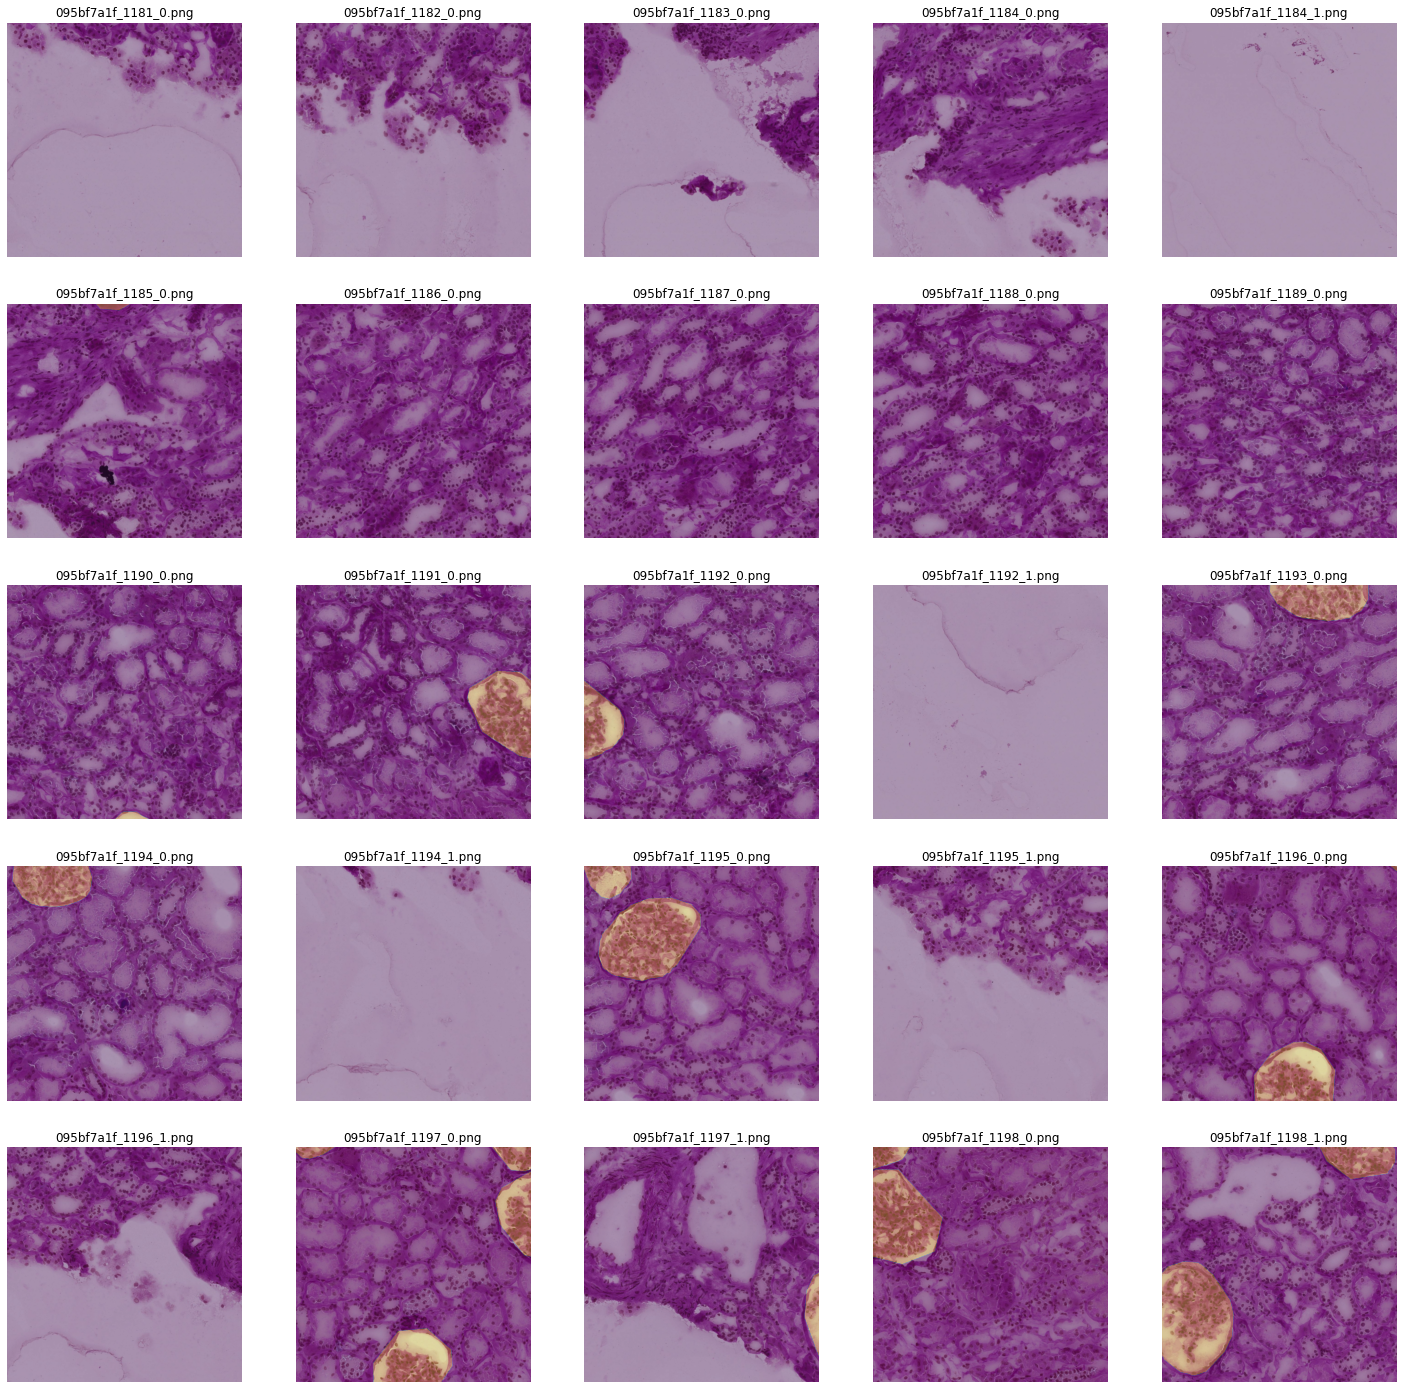

In [9]:
NUM = 5
columns, rows = NUM, NUM
idx0 = 1150
fig = plt.figure(figsize = (columns * NUM, rows * NUM))
fnames = sorted(sorted(os.listdir(TILES_PATH)))
for i in range(rows):
    for j in range(columns):
        idx = i + j * columns
        img = cv2.imread(f'{TILES_PATH}/{fnames[idx0 + idx]}')
        mask = cv2.imread(f'{MASKS_PATH}/{fnames[idx0 + idx]}',
                          cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(rows, columns, idx + 1)
        plt.axis('off')
        plt.imshow(Image.fromarray(img))
        plt.imshow(Image.fromarray(mask), alpha = 0.3)
        plt.title(fnames[idx0 + idx])
plt.show()